In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Input, Output

In [2]:
df = pd.read_excel('https://query.data.world/s/l2umdny2hjfu7jmo6f4wroj6t33ssi')

In [3]:
df.drop(columns = ['studyName', 'Sample Number', 'Region', 'Stage', 'Clutch Completion', 'Date Egg', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments'], inplace = True)

In [4]:
df['Species'] = df.Species.map(lambda x: x.split(' ')[0])
df['Sex'] = df.Sex.fillna('.').map(lambda x: 'UNKNOWN' if x == '.' else x)
df.dropna(inplace = True)

In [5]:
df.groupby(['Species']).mean()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g)
Species,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252
Chinstrap,48.833824,18.420588,195.823529,3733.088235
Gentoo,47.504878,14.982114,217.186992,5076.016260


In [6]:
df.loc[df.Sex != 'UNKNOWN'].groupby(['Species', 'Sex']).mean()

Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
Species   Sex                                                                  
Adelie    FEMALE           37.257534          17.621918           187.794521   
          MALE             40.390411          19.072603           192.410959   
Chinstrap FEMALE           46.573529          17.588235           191.735294   
          MALE             51.094118          19.252941           199.911765   
Gentoo    FEMALE           45.563793          14.237931           212.706897   
          MALE             49.473770          15.718033           221.540984   

                  Body Mass (g)  
Species   Sex                    
Adelie    FEMALE    3368.835616  
          MALE      4043.493151  
Chinstrap FEMALE    3527.205882  
          MALE      3938.970588  
Gentoo    FEMALE    4679.741379  
          MALE      5484.836066

In [7]:
df.groupby(['Island', 'Species']).count().iloc[:,1]

Island     Species  
Biscoe     Adelie        44
           Gentoo       123
Dream      Adelie        56
           Chinstrap     68
Torgersen  Adelie        51
Name: Culmen Length (mm), dtype: int64

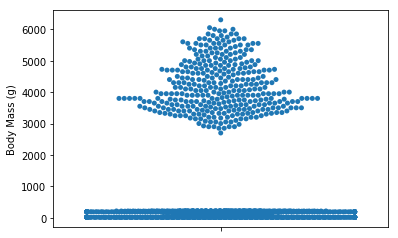

In [8]:
for attribute in ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)','Body Mass (g)']:
    ax = sns.swarmplot(data = df, y = attribute)
    offsets = pd.DataFrame(ax.collections[0].get_offsets())[[0]]
    offsets.columns = [attribute + ' Offset']
    df = df.sort_values(by = attribute).reset_index().drop(columns = ['index'])
    df = pd.merge(df, offsets, left_index = True, right_index = True)

In [9]:
df.to_csv('W28.csv', index = False)

In [2]:
df = pd.read_csv('W28.csv')

In [3]:
df_species = df.loc[df.Species == 'Adelie']

In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df['Flipper Length (mm) Offset'], y = df['Culmen Length (mm)'], mode = 'markers', marker = {'color': 'grey'}, showlegend = False))
fig.add_trace(go.Scatter(x = df_species['Culmen Length (mm) Offset'], y = df_species['Culmen Length (mm)'], mode = 'markers', marker = {'color': 'red'}, showlegend = False))

fig.update_layout(xaxis = {'showgrid': False, 'showticklabels': False})
fig.update_layout(yaxis = {'showgrid': False, 'showticklabels': False})
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

fig.show()

In [5]:
df['Culmen Length Normalised'] = (df['Culmen Length (mm)'] - df['Culmen Length (mm)'].min()) / (df['Culmen Length (mm)'].max() - df['Culmen Length (mm)'].min())
df['Culmen Depth Normalised'] = (df['Culmen Depth (mm)'] - df['Culmen Depth (mm)'].min()) / (df['Culmen Depth (mm)'].max() - df['Culmen Depth (mm)'].min())
df['Flipper Length Normalised'] = (df['Flipper Length (mm)'] - df['Flipper Length (mm)'].min()) / (df['Flipper Length (mm)'].max() - df['Flipper Length (mm)'].min())
df['Body Mass Normalised'] = (df['Body Mass (g)'] - df['Body Mass (g)'].min()) / (df['Body Mass (g)'].max() - df['Body Mass (g)'].min())

In [6]:
df_grouped = df.groupby(['Species']).mean().iloc[:,-4:].reset_index()

In [7]:
attributes = [x[:-11] for x in df_grouped.columns[1:]]

In [8]:
df_species = df_grouped.loc[df_grouped.Species == 'Adelie']
r_species = list(df_species.reset_index().iloc[0,2:]) + [df_species.reset_index().iloc[0,2]]

In [17]:
fig = go.Figure()

for species in ['Adelie', 'Chinstrap', 'Gentoo']:
    df_subset = df_grouped.loc[df_grouped.Species == species]
    r_subset = list(df_subset.reset_index().iloc[0,2:]) + [df_subset.reset_index().iloc[0,2]]
    fig.add_trace(go.Scatterpolar(r = r_subset, theta = [0,90,180,270,0], mode = 'lines', line = {'color': 'grey'}, showlegend = False, fill = 'toself'))
fig.add_trace(go.Scatterpolar(r = r_species, theta = [0,90,180,270,0], mode = 'lines', line = {'color': 'red'}, showlegend = False, fill = 'toself'))

fig.update_layout(polar = {'radialaxis': {'showgrid': False, 'ticks': '', 'tickvals': [0], 'ticktext': [''], 'showline': False},
    'angularaxis': {'showgrid': False, 'ticks': '', 'tickvals': [0,90,180,270], 'ticktext': attributes}})
fig.update_layout(template = None)

fig.show()


In [5]:
app = JupyterDash(external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = html.Div(children=[
    dbc.Row([
        dbc.Col([
            html.Div([
                html.H1('Palmer Penguins Exploration'),
                html.Br()],
            style = {'textAlign': 'center'})])]),
    dbc.Row([
        dbc.Col([
            html.Div([
                html.H2('Meet the Penguins!'),
                html.P("Hello, our names are Chinstrap, Gentoo and Adelie, the three species of penguin that can be found in the islands of Palmer Archipelogo, Antarctica."),
                html.Img(src='https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/lter_penguins.png', width = 450, height = 300),
                html.P("Whilst they were here, researchers from the Palmer Station LTER decided to take measurements of some of the features that distinguish us from each other, including our bill lengths and depths (below), flipper lengths and body masses. Play around with the dropdowns provided (top right) to see how we compare!"),
                html.Img(src='https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/culmen_depth.png', width = 450, height = 300)])]),
        dbc.Col([
            dbc.Row([
                dbc.Col([
                    html.Div([
                        html.H6('Pick a Penguin:')
                    ], style = {'textAlign': 'center'})
                ]),
                dbc.Col([
                    html.Div([
                        html.H6('Pick a Feature:')
                    ], style = {'textAlign': 'center'})
                ])]),
            dbc.Row([
                dbc.Col([
                    html.Div([
                        dcc.Dropdown(
                            id='penguin-dropdown',
                            options=[{'label': 'Chinstrap', 'value': 'Chinstrap'}, {'label': 'Gentoo', 'value': 'Gentoo'}, {'label': 'Adelie', 'value': 'Adelie'}],
                            value='Adelie',
                            style = {'width': '250px', 'margin': 'auto', 'textAlign': 'center'})
                    ])
                ]),
                dbc.Col([
                    html.Div([
                        dcc.Dropdown(
                            id='feature-dropdown',
                            options=[{'label': 'Bill Length', 'value': 'Culmen Length (mm)'}, {'label': 'Culmen Depth', 'value': 'Culmen Depth (mm)'}, {'label': 'Flipper Length', 'value': 'Flipper Length (mm)'}, {'label': 'Body Mass', 'value': 'Body Mass (g)'}],
                            value='Culmen Length (mm)',
                            style = {'width': '250px', 'margin': 'auto', 'textAlign': 'center'})
                    ])
                ])]),
            dbc.Row([
                dcc.Graph(
                    id='swarm-plot')])])]),
    dbc.Row([
        dbc.Col([
            html.Div([
                html.Span('Data Source: Palmer LTER | Artwork by: Allison Horst (@allison_horst) | Created by: Jack Tann (@jacktann3)',
                    style={'color': 'grey', 'font-size': 11})],
                style = {'textAlign': 'right'})])])],
        style = {'width': '90%', 'margin': 'auto'})

@app.callback(
    Output('swarm-plot', 'figure'),
    [Input('penguin-dropdown', 'value'),
    Input('feature-dropdown', 'value')])

def update_figure(selected_penguin, selected_feature):
    df_species = df.loc[df.Species == selected_penguin]

    penguin_colors = {'Chinstrap': 'rgb(192,92,203)', 'Gentoo': 'rgb(44,112,118)', 'Adelie': 'rgb(239,109,48)'}
    penguin_color = penguin_colors[selected_penguin]

    background_markers = [go.Scatter(
        x = df[selected_feature + ' Offset'], 
        y = df[selected_feature], 
        mode = 'markers', 
        marker = {'color': 'darkgrey', 'size': 10}, 
        showlegend = False,
        hoverinfo = 'skip')]

    foreground_markers = [go.Scatter(
        x = df_species[selected_feature + ' Offset'], 
        y = df_species[selected_feature],  
        mode = 'markers', 
        marker = {'color': penguin_color, 'size': 10}, 
        showlegend = False,
        hoverinfo = 'skip')]

    data = background_markers + foreground_markers

    layout = go.Layout(
        xaxis = {'showgrid': False, 'showticklabels': False, 'zeroline': False},
        yaxis = {'showgrid': False, 'showline': True, 'title': selected_feature},
        width = 800,
        height = 700,
        margin= {'l': 60, 'r': 0, 't': 20, 'b': 0},
        paper_bgcolor='rgba(0,0,0,0)', 
        plot_bgcolor='rgba(0,0,0,0)')

    return {
            'data': data,
            'layout': layout
    }

In [6]:
app.run_server(mode='external')

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

Dash app running on http://127.0.0.1:8050/
